**Github with Tutorial Code**

https://github.com/DataGasmic/PyData-London-2022-Tutorial-Stacking-Neural-Nets-Together

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
import os
from   PIL import Image
from   tensorflow.keras.utils               import img_to_array
from   tensorflow.keras.utils               import image_dataset_from_directory
from   tensorflow.keras.preprocessing.image import ImageDataGenerator
from   tensorflow.keras.layers              import Input, concatenate
from   tensorflow.keras.models              import Model


from   sklearn.model_selection              import train_test_split
from   sklearn.decomposition                import PCA
from   sklearn.preprocessing                import StandardScaler
from   sklearn.preprocessing                import MinMaxScaler
from   sklearn.metrics                      import mean_absolute_error
from   zipfile import ZipFile

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
! mkdir ~/.kaggle          # Making New File Directory
!cp kaggle.json ~/.kaggle/ # New File Path
! chmod 600 ~/.kaggle/kaggle.json  ## Permission

In [ ]:
!kaggle datasets download -d ted8080/house-prices-and-images-socal

 99% 364M/369M [00:03<00:00, 164MB/s]
100% 369M/369M [00:03<00:00, 98.8MB/s]


# Preprocessing

In [ ]:
class LoadText:

  def __init__(self):
    self.zip_file    = 'house-prices-and-images-socal.zip'

  # Returns training/test data
  def train_test_metadata(self):

    text_data                        = self.load_metadata()
    x_train, x_test, y_train, y_test = self.preprocess_metadata(text_data)

    return x_train, x_test, y_train, y_test

  # Loads Data From Zip File
  def load_metadata(self):
    with ZipFile(self.zip_file) as zip:
      with zip.open(zip.namelist()[0], 'r') as zip_file:
        text_data = pd.read_csv(zip_file)

    return text_data

  # Preprocess Training/Test Data
  def preprocess_metadata(self, text_data):

    Normalizer = MinMaxScaler()

    target     = text_data['price']
    x_data     = text_data.drop(columns = ['price', 'image_id', 'street', 'citi', 'n_citi'])
    x_data     = Normalizer.fit_transform(x_data)
    target     = np.array(target).astype(float)

    # Exact test size because train_images loaded through batches = 12384 for training 19965
    x_train, x_test, y_train, y_test = train_test_split(x_data, target, test_size = 0.2, 
                                                        shuffle = False, random_state = 42)
    
    return x_train, x_test, y_train, y_test

  def load_images(self):

    return

text_data                        = LoadText().load_metadata()
x_train, x_test, y_train, y_test = LoadText().train_test_metadata()


**Extract and Load Images**

In [ ]:
class LoadImages:

  def __init__(self):
    self.zip_path      = 'house-prices-and-images-socal.zip'
    self.extract_images()
    self.IMG_WIDTH     = 128
    self.IMG_HEIGHT    = 128
    self.BATCH_SIZE    = 32

  def extract_images(self):
    image_id = re.compile(r'/(\d+)\.jpg')
    with ZipFile(self.zip_path, 'r') as zip_file:
        zip_file.extractall('dataset')

  def load_images(self):
    # Load Images
    labels         = os.listdir('/content/dataset/socal2/socal_pics')
    file_dataset   = tf.data.Dataset.list_files('/content/dataset/socal2/socal_pics/*.jpg', shuffle=False)

    # Count the total number of examples:
    n = len(list(file_dataset))

    # Decide how many examples should go into the training set:
    train_examples = int(n * 0.8)  # 80% for training

    train_dataset  = file_dataset.take(train_examples)
    test_dataset   = file_dataset.skip(train_examples)

    img_train      = train_dataset.map(self.process_path).batch(self.BATCH_SIZE,  drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
    img_test       = test_dataset.map(self.process_path).batch(self.BATCH_SIZE,  drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)


    img_train_dataset   = img_train.map(lambda x, y: x)
    label_train_dataset = img_train.map(lambda x, y: y)

    img_test_dataset    = img_test.map(lambda x, y: x)
    label_test_dataset  = img_test.map(lambda x, y: y)

    return img_train_dataset, img_test_dataset


  # Load the Images Into Tensors
  def process_path(self, file_path):
      
      # load the raw data from the file as a string
      img          = tf.io.read_file(file_path)
      # convert the compressed string to a 3D uint8 tensor
      img          = tf.image.decode_jpeg(img, channels=3)
      # Use `convert_image_dtype` to convert to floats in the [0,1] range.
      img          = tf.image.convert_image_dtype(img, tf.float32)

      labels       = os.listdir('/content/dataset/socal2/socal_pics')
      image_id     = re.compile(r'(\d+)\.jpg')

      text_data     = LoadText().load_metadata()

      labels_tensor = tf.convert_to_tensor(text_data['price'].values)  # Replace 'price' with the column name of your label
      label         = labels_tensor[self.get_index_from_file_path(file_path)]

      img          = tf.image.resize(img, [self.IMG_WIDTH, self.IMG_HEIGHT])
      # resize the image to the desired size.
      
      
      return img, label

  # Get Index of Img from Image Name
  def get_index_from_file_path(self, file_path):
      # Extract the file name from the file path.
      file_name = tf.strings.split(file_path, os.sep)[-1]
      
      # Extract the index from the file name.
      index     = tf.strings.to_number(tf.strings.regex_replace(file_name, ".jpg", ""), out_type=tf.dtypes.int32)
      return index

  
  def img_dimensions(self):

    return self.IMG_WIDTH, self.IMG_HEIGHT


img_instance = LoadImages()

img_train_dataset, img_test_dataset = img_instance.load_images()


**DataFrame Preprocessing (Text_data)**

In [ ]:
Normalizer = MinMaxScaler()

target    = text_data['price']
x_data    = text_data.drop(columns = ['price', 'image_id', 'street', 'citi', 'n_citi'])

x_data    = Normalizer.fit_transform(x_data)
# x_data    = np.array(x_data)
target    = np.array(target).astype(float)
# target    = np.expand_dims(target, axis = -1)

# Exact test size because train_images loaded through batches = 12384 for training 19965
x_train, x_test, y_train, y_test = train_test_split(x_data, target, test_size = 0.2, 
                                                    shuffle = False, random_state = 42)

# Nueral Network Generation

**Only MetaData For Comparision**

In [ ]:
textonly = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, input_shape = (3,), activation = 'relu'),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(16, activation = 'relu'),
    tf.keras.layers.Dense(1)
])

textonly.compile(loss = 'mae', metrics = ['mae'], optimizer = 'adam')
textonly.summary()
history_text = textonly.fit(x_train, y_train, epochs = 20)


In [ ]:
predictions  = textonly.predict(x_test)
mean_absolute_error(predictions, y_test)

97/97 [==============================] - 0s 1ms/step


235062.7099858643

**Image NN Pretrained**

In [ ]:
IMG_WIDTH, IMG_HEIGHT = img_instance.img_dimensions()
image_size            = (IMG_WIDTH, IMG_HEIGHT)
VGG19                 = tf.keras.applications.VGG19(include_top = False,     # default size by TF
                                    weights        = 'imagenet',      #Path to the file we want ot train.
                                    input_shape    = (image_size[0], image_size[1], 3)) # custom input size

for layer in VGG19.layers: # Locks the Layers of the Model, so only the layers we add are trainable
  layer.trainable = False

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
# class StackedModel:

#   def __init__(self):
#     VGG19         = self.VGG19()
#     meta_model    = self.metamodel()
#     stacked_model = self.stack_models(VGG19, meta_model)

#   def VGG19(self):
#     IMG_WIDTH, IMG_HEIGHT = img_instance.img_dimensions()
#     image_size            = (IMG_WIDTH, IMG_HEIGHT)
#     VGG19                 = tf.keras.applications.VGG19(include_top = False,     # default size by TF
#                                         weights        = 'imagenet',      #Path to the file we want ot train.
#                                         input_shape    = (image_size[0], image_size[1], 3)) # custom input size

#     for layer in VGG19.layers: # Locks the Layers of the Model, so only the layers we add are trainable
#       layer.trainable = False

#     self.image_model = tf.keras.models.Sequential([
#     VGG19,
#     tf.keras.layers.GlobalAveragePooling2D(),
#     ])
    
#     self.input_image        = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3), name = 'Image')
#     self.processed_image    = self.image_model(self.input_image)

#     return self.processed_image

#   def metamodel(self):

#     self.meta_model          = tf.keras.layers.Dense(64, activation = 'relu')
#     self.input_metadata      = Input(shape=(3,), name = 'Numeric')
#     self.processed_metadata  = self.meta_model(self.input_metadata)

#     return self.processed_metadata

#   def stack_models(self, processed_image, processed_metadata):
#     combined           = concatenate([processed_image, processed_metadata])
#     combined           = tf.keras.layers.Dense(64, activation='relu')(combined)
#     output             = tf.keras.layers.Dense(1)(combined)

#     self.model              = Model(inputs=[processed_image, processed_metadata], outputs=[output])
#     self.model.compile(optimizer='adam', loss='mae', loss_weights=[0.1, 1])  # Use Mean Squared Error loss for regression
    
#     return self.model

#   def get_model(self):

#     return self.model

#   def model_summary(self, model):
#     return model.summary()

#   def plot(self):
#     return tf.keras.utils.plot_model(self.model, show_shapes = True)

#   def fit_model(self, model):
#     return model.fit()

# model_instance = StackedModel()
# model = model_instance.get_model()

image_model = tf.keras.models.Sequential([
    VGG19,
    tf.keras.layers.GlobalAveragePooling2D(),
    # tf.keras.layers.Flatten(),
])


meta_model         = tf.keras.layers.Dense(64, activation = 'relu')

input_image        = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3), name = 'Image')
input_metadata     = Input(shape=(3,), name = 'Numeric')

processed_metadata = meta_model(input_metadata)
processed_image    = image_model(input_image)

combined           = concatenate([processed_image, processed_metadata])
combined           = tf.keras.layers.Dense(64, activation='relu')(combined)
output             = tf.keras.layers.Dense(1)(combined)

model              = Model(inputs=[input_image, input_metadata], outputs=[output])
model.compile(optimizer='adam', loss='mae', loss_weights=[0.1, 1])  # Use Mean Squared Error loss for regression
# model.summary()

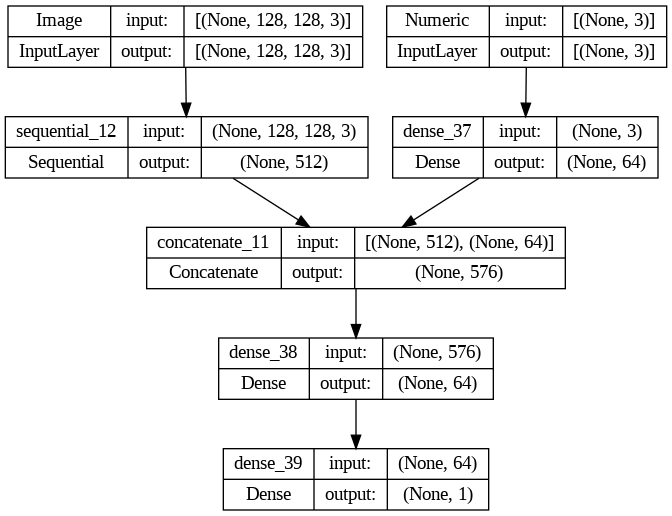

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True)

**Additional Preprocessing to assure IMG and Metadata compatability**

In [ ]:
def preprocess_model(img_features, meta_features, targets):
  prices_ds     = tf.data.Dataset.from_tensor_slices(targets).batch(32, drop_remainder = True)
  metadata_ds   = tf.data.Dataset.from_tensor_slices(meta_features).batch(32, drop_remainder = True)
  
  final_dataset = tf.data.Dataset.zip((img_features, metadata_ds, prices_ds))
  final_dataset = final_dataset.map(map_func)

  return final_dataset

def map_func(image, meta, price):
    return ((image, meta), price)
    
test_dataset  = preprocess_model(img_test_dataset, x_test, y_test)
train_dataset = preprocess_model(img_train_dataset,x_train, y_train)


In [ ]:
history          = model.fit(train_dataset, epochs =10, verbose = 1)

Epoch 1/10
 43/386 [==>...........................] - ETA: 18s - loss: 59406.5039

KeyboardInterrupt: ignored

In [ ]:
predictions = model.predict(test_dataset)
y_test      = y_test[:3072]
mean_absolute_error(predictions, y_test)

96/96 [==============================] - 5s 54ms/step


253737.1085103353